In [84]:
#Get the dataset and drop incomplete data rows

import pandas as pd
import numpy as np
df = pd.read_excel("LAhousing.xlsx")

# dropping rows with 0 pop, area, targetvalue, yearbuilt, effectiveyearbuilt
df = df[:][df['Total Population']!=0]
df = df[:][df["SQFTmain"]!=0]
df = df[:][df['isTaxableParcel?']!='N']
df = df[:][df["YearBuilt"]!=0]
df = df[:][df["EffectiveYearBuilt"]!=0]

#dropping outliers
#mean = df["TotalValue"].mean()
#std = df["TotalValue"].std()
#df = df[:][df["TotalValue"]<mean+3*std]
#df = df[:][df['TotalValue']>mean-3*std]


# Transforming Property Use Code
df.fillna({'SpecificUseType':'','SpecificUseDetail1':'','SpecificUseDetail2':''},inplace=True)
df['PropertyUseCode'] = df['PropertyUseCode'].apply(lambda x: str(x)+" ")+df['SpecificUseType'].apply(lambda x: str(x)+" ")+df['SpecificUseDetail1'].apply(lambda x: str(x)+" ")+df['SpecificUseDetail2'].apply(lambda x: str(x))
df.drop(['SpecificUseType','SpecificUseDetail1','SpecificUseDetail2'],axis=1,inplace=True)
# combining categories with low frequency
for i,val in zip(df.index,df['PropertyUseCode']):
    if int(val[:2])>=5:
        df['PropertyUseCode'].loc[i] = '05xx- 5 or more units'
    elif int(val[:2])==4:
        df['PropertyUseCode'].loc[i] = '04xx- 4 units'
    elif int(val[:2])==3:
        df['PropertyUseCode'].loc[i] = '03xx- 3 units'
    elif int(val[:2])==2:
        df['PropertyUseCode'].loc[i] = '02xx- 2 units'
    elif (val[:4]!='0100')and(val[:4]!='0101')and(val[:4]!='010C'):
        df['PropertyUseCode'].loc[i] = '01xx- 1 units other'
df['PropertyUseCode'].value_counts()


#Changing recording date to desired format
df = df[:][df['RecordingDate'].apply(lambda x:str(x)[6:])<='31']
l = pd.to_datetime([20190101]*len(df),format='%Y%m%d')
l.index = df['RecordingDate'].index
df['RecordingDate'] = pd.to_numeric(l-pd.to_datetime(df['RecordingDate'],format='%Y%m%d'))/100000000000

#Making new col AdministrativeRegion_Cluste by combining AdministrativeRegion and cluster
df['AdministrativeRegion_Cluster']= df['AdministrativeRegion']*100000+df['Cluster']
#keeping only relevant cols 
#discartding others
df = df[['ZIPcode5','RecordingDate','PropertyUseCode',
    'totBuildingDataLines', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain',
    'Bedrooms', 'Bathrooms', 'Units', 'CENTER_LAT',
    'CENTER_LON', 'Total Housing Units', 'Total Population',
    'Occupied Houses', 'Avg Household Size', 'Avg Household Size(Occupied)',
    'Avg Household Size(Rented)', 'Total Household Size', 'Urban Housing',
    'Population above 18', 'Median Age', 'Urban Pop',
    'AdministrativeRegion_Cluster','TotalValue']]
df=df.astype({'ZIPcode5':'object','totBuildingDataLines':'object'})

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [85]:
#Importing libraries
!pip install category_encoders
from sklearn.model_selection import train_test_split
from scipy.special import inv_boxcox1p,boxcox1p
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.compose import TransformedTargetRegressor
from category_encoders.cat_boost import CatBoostEncoder

#splitting dataset
y = np.array(df['TotalValue'])
X = df.drop(['TotalValue'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=2021)

In [86]:
# function for applying box-cox transformation (not used however, since results were similar with/without transformations)
def prep_box_cox(df):
    df['SQFTmain']=boxcox1p(df['SQFTmain'],0)
    df['Bedrooms']=boxcox1p(df['Bedrooms'],0)
    df['Bathrooms']=boxcox1p(df['Bathrooms'],0)
    df['Total Housing Units']=boxcox1p(df['Total Housing Units'],0)
    df['Total Population']=boxcox1p(df['Total Population'],0)
    df['Occupied Houses']=boxcox1p(df['Occupied Houses'],0)
    df['Total Household Size']=boxcox1p(df['Total Household Size'],0)
    df['Urban Housing']=boxcox1p(df['Urban Housing'],0)
    df['Population above 18']=boxcox1p(df['Population above 18'],0)
    df['Urban Pop']=boxcox1p(df['Urban Pop'],0)
    return df

In [87]:
# defining preprocessor 
# c1_cols - categorical cols with large no. of categories
# c2_cols - categorical cols with small no. of categories

c1_cols = ['ZIPcode5']
c2_cols = ['PropertyUseCode','totBuildingDataLines']
numerical_cols = ['RecordingDate', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain',
       'Bedrooms', 'Bathrooms', 'Units', 'CENTER_LAT',
       'CENTER_LON', 'Total Housing Units', 'Total Population',
       'Occupied Houses', 'Avg Household Size', 
       'Avg Household Size(Occupied)',
       'Avg Household Size(Rented)',
       'Total Household Size', 'Urban Housing',
       'Population above 18', 'Median Age', 'Urban Pop',
       'AdministrativeRegion_Cluster']
# Preprocessing for numerical data
numerical_transformer = StandardScaler()
# Preprocessing for categorical data type 1 (one hot encoding)
categorical_transformer1 = CatBoostEncoder()
# Preprocessing for categorical data type 2 (label encoding)
categorical_transformer2 = OneHotEncoder()

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat1', categorical_transformer1, c1_cols),
    ('cat2', categorical_transformer2, c2_cols)])
                       

In [88]:
# Defining different ML models
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
import joblib

ridge = RidgeCV(cv=5)

lasso = LassoCV(max_iter=1e6,cv=5)

elasticnet = ElasticNetCV(max_iter=1e6,cv=5)

svr = SVR(C=20, epsilon=0.01, tol=1e-3)


lightgbm = LGBMRegressor(objective='regression',
                         num_leaves=5,
                         learning_rate=0.01,
                         n_estimators=1000
                         )

xgb = XGBRegressor(learning_rate = 0.01, max_depth = 10, n_estimators= 1300)

# stack
stack_gen = StackingRegressor(estimators=[('a',ridge), ('b',lasso),
                                          ('d',xgb), ('e',lightgbm)],
                                final_estimator=xgb,
                                n_jobs=-1)

In [89]:
models = {"Ridge Regression":ridge,
          "Lasso Regression":lasso,
          "ElasticNet Regression":elasticnet,
          "SVM Regression":svr,
          "LightGBM Regression":lightgbm,
          "XGBoost Regression":xgb,
          "Stacked Model":stack_gen
         }

In [90]:
#checking scores for different models


#for model in models.keys():
#    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                              ('model', models[model])
#                             ])
#    my_pipeline.fit(X_train,y_train)
#    y_test_hat = my_pipeline.predict(X_test)
#    print("Model : ",model)
#    print("MAvE on test set ",median(abs(y_test_hat-y_test)))

In [91]:
# XGBoost regression performs the best, hence will be used for further modelling

import seaborn as sns
import matplotlib.pyplot as plt
from statistics import median_high
from statistics import median

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb)
                             ])
my_pipeline.fit(X_train,y_train)
y_train_hat = my_pipeline.predict(X_train)
y_test_hat = my_pipeline.predict(X_test)
print("RMSE on train set",np.sqrt(((y_train_hat-y_train)**2).mean()))
print("RMSE on test set",np.sqrt(((y_test_hat-y_test)**2).mean()))
print("MAE on train set",abs(y_train_hat-y_train).mean())
print("MAE on test set",abs(y_test_hat-y_test).mean())
print("MAvE on train set",median(abs(y_train_hat-y_train)))
print("MAvE on test set",median(abs(y_test_hat-y_test)))
print("example: predicted, actual")
for i in range(10):
  print(y_test_hat[i],y_test[i])


[08:58:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on train set 170056.72497729573
RMSE on test set 933951.0233843167
MAE on train set 105882.01699074812
MAE on test set 279942.30310307717
MAvE on train set 71075.25
MAvE on test set 126517.25
example: predicted, actual
205126.81 222267
2718503.0 1045455
310424.84 331846
192485.95 145344
307744.38 230877
679586.9 878600
284637.34 229339
387756.47 93676
732433.44 855000
356150.4 439707


In [92]:
def err_analysis1(X,y,y_hat):
    # Individual error analysis for different ranges of target value
    # scatterplot for error
    f = plt.subplots(figsize=(20,10))
    sns.scatterplot(x=y,y=abs(y-y_hat))
    # breaking up target set into bins for analysis 
    ranges = pd.interval_range(start=y.min(), end= y.max(), periods=30)
    # dictionary for mapping target with error
    dict1={}
    for i,p in zip(y,my_pipeline.predict(X)): 
        dict1[i]=abs(i-p)
    #
    dict2={}

    med = [] # stores median for different ranges
    # Calculating median for different ranges and error % w.rt. median for points 
    for i in ranges:
        l = [x for x in dict1.keys() if x>i.left and x<=i.right]
        if len(l)!=0:
            rr = median_high(l)
            med.append(rr)
            r1=r2=r3=r4=0
            for c in l:
                if dict1[c]>=0.4*rr:
                    r4=r4+1
                elif dict1[c]>=0.2*rr:
                    r3=r3+1
                elif dict1[c]>=0.1*rr:
                    r2=r2+1
                else:
                    r1=r1+1
            dict2[i]={"No. of data points":len(l),"Median":rr,"Err<10%":r1/len(l),"Err<20%":r2/len(l),"Err<40%":r3/len(l),"Err>40%":r4/len(l)}
        else:
            dict2[i]={"No. of data points":len(l),"Median":int((i.left+i.right)/2),"Err<10%":0,"Err<20%":0,"Err<40%":0,"Err>40%":0}
    err = [dict1[x] for x in med] #

    dict2 = pd.DataFrame(dict2)
    dict2 = dict2.T
    dict2 = dict2.astype({"Median":"int","No. of data points":"int"})

    #print error %
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', -1)
    display(dict2)
    #print MAvE for each range
    display(pd.DataFrame(zip(ranges,err),columns=['range','median abs error']))
    #plotting results
    fig = plt.subplots(figsize =(25, 10))
    N = np.arange(len(dict2))
    width = 0.5
    p1 = plt.bar(N,dict2['Err<10%'], width)
    p2 = plt.bar(N,dict2['Err<20%'], width, bottom =dict2['Err<10%'])
    p3 = plt.bar(N,dict2['Err<40%'], width, bottom =dict2['Err<20%']+dict2['Err<10%'])
    p4 = plt.bar(N,dict2['Err>40%'], width, bottom =dict2['Err<40%']+dict2['Err<20%']+dict2['Err<10%'])

    plt.ylabel('Error wrt median')
    plt.xlabel('Total Value')
    plt.title('Error % for different bins')
    plt.xticks(N,dict2.Median)
    #plt.yticks()
    plt.legend((p1,p2,p3,p4), ('Err<10%', 'Err<20%','Err<40%','Err>40%'))
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,No. of data points,Median,Err<10%,Err<20%,Err<40%,Err>40%
"(9.0, 3687355.066666667]",8950,361772,0.280782,0.206704,0.258771,0.253743
"(3687355.066666667, 7374701.133333334]",92,4503443,0.684783,0.119565,0.097826,0.097826
"(7374701.133333334, 11062047.200000001]",13,9126388,0.692308,0.230769,0.076923,0.000000
"(11062047.200000001, 14749393.266666668]",5,12197675,0.800000,0.000000,0.000000,0.200000
"(14749393.266666668, 18436739.333333336]",4,18056756,0.500000,0.250000,0.000000,0.250000
"(18436739.333333336, 22124085.400000002]",1,18653810,1.000000,0.000000,0.000000,0.000000
"(22124085.400000002, 25811431.46666667]",0,23967758,0.000000,0.000000,0.000000,0.000000
"(25811431.46666667, 29498777.533333335]",0,27655104,0.000000,0.000000,0.000000,0.000000
"(29498777.533333335, 33186123.6]",0,31342450,0.000000,0.000000,0.000000,0.000000
"(33186123.6, 36873469.66666667]",2,36330713,1.000000,0.000000,0.000000,0.000000


,range,median abs error
0,"(9.0, 3687355.066666667]",18307.59375
1,"(3687355.066666667, 7374701.133333334]",625599.25000
2,"(7374701.133333334, 11062047.200000001]",92622.00000
3,"(11062047.200000001, 14749393.266666668]",35489.00000
4,"(14749393.266666668, 18436739.333333336]",65482.00000
5,"(18436739.333333336, 22124085.400000002]",15336.00000
6,"(22124085.400000002, 25811431.46666667]",487417.00000
7,"(25811431.46666667, 29498777.533333335]",24973.00000
8,"(29498777.533333335, 33186123.6]",708.00000
9,"(33186123.6, 36873469.66666667]",164815.00000


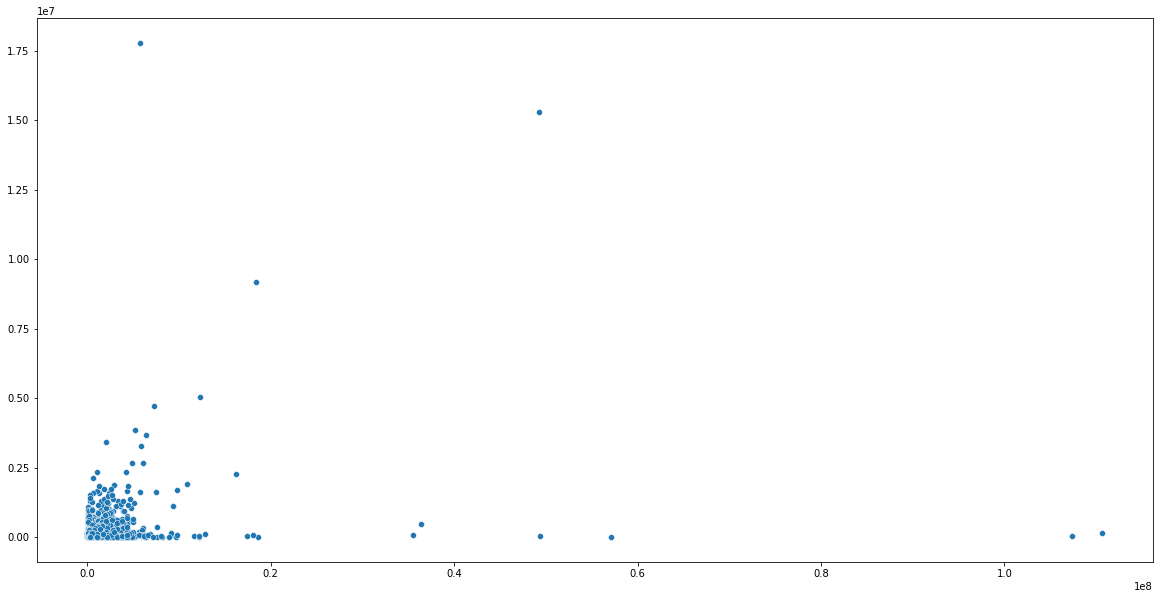

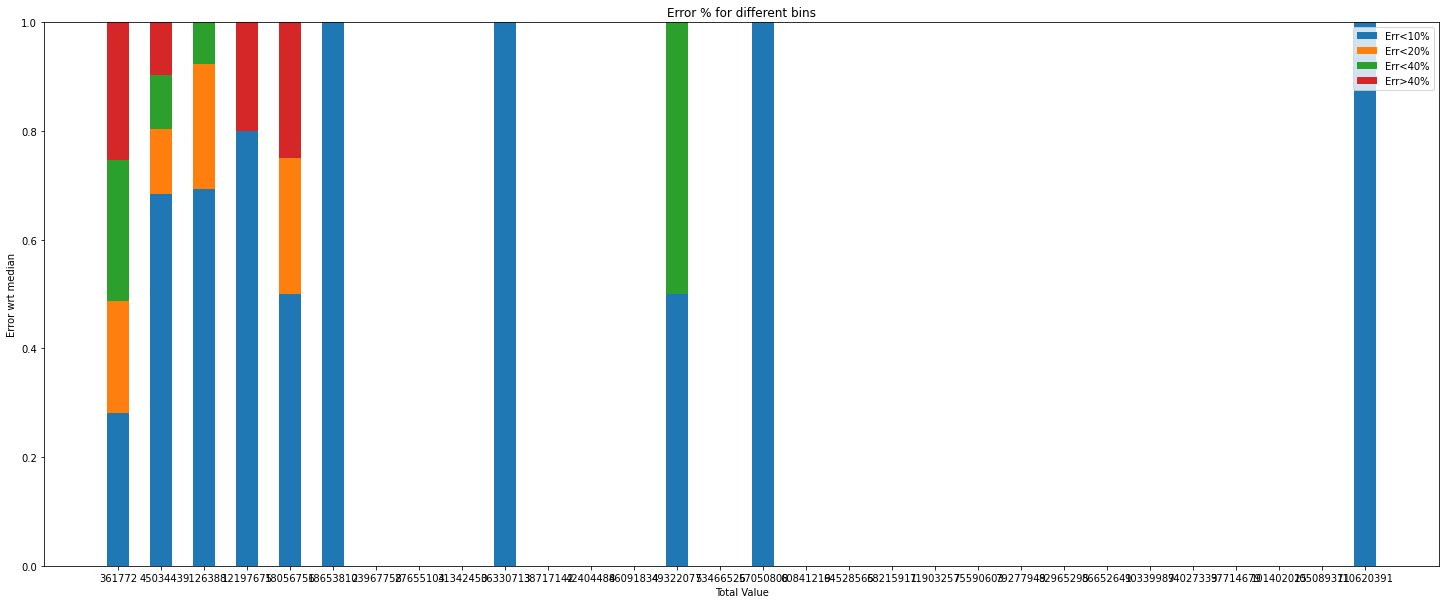

In [93]:
err_analysis1(X,y,my_pipeline.predict(X))

In [94]:
def err_analysis2(X,y,y_hat):
    # groupwise error analysis
    # breaking up target set into bins for analysis 
    ranges = pd.interval_range(start=y.min(), end= y.max(), periods=20)
    # dictionary for mapping target variable with error
    dict1={}
    for i,p in zip(y,my_pipeline.predict(X)): 
        dict1[i]=abs(i-p)

    errcols={} #saves names and categories

    #err analysis for categorical type 1 cols
    for col in c1_cols:
        unique = X[col].unique()
        dictt = {}
        q = []
        for un in unique:
            l = list(pd.Series(pd.CategoricalIndex(data=X[col],categories = [un])).notna())
            points = X[:][l]
            errs = [dict1[x]/x for x in list(df['TotalValue'][points.index])]
            med = median(errs)
            dictt[un] = med
            q.append([un,med])
        if len(q)!=0:
            errcols[col]=q
        fig = plt.subplots(figsize =(20, 7))
        N = np.arange(len(dictt))
        width = 0.75
        p1 = plt.bar(N,dictt.values(), width)
        plt.ylabel('MAPE')
        plt.xlabel('Category')
        plt.xticks(N,dictt.keys(),rotation='vertical')
        plt.title("Median percentage error for column {}".format(col))
        plt.show()

    # for type 2 categorical cols
    for col in c2_cols:
        unique = X[col].unique()
        dictt = {}
        q=[]
        for un in unique:
            l = list(pd.Series(pd.CategoricalIndex(data=X[col],categories = [un])).notna())
            points = X[:][l]
            errs = [dict1[x]/x for x in list(df['TotalValue'][points.index])]
            med = median(errs)
            dictt[un] = med
            q.append([un,med])
        if len(q)!=0:
            errcols[col]=q
        fig = plt.subplots(figsize =(20,7))
        N = np.arange(len(dictt))
        width = 0.75
        p1 = plt.bar(N,dictt.values(), width)
        plt.ylabel('MAPE')
        plt.xlabel('Category')
        plt.xticks(N,dictt.keys(),rotation='vertical')
        plt.title("Median percentage error for column  {}".format(col))
        plt.show() 
    
    # for numerical cols
    for col in numerical_cols:
        unique = pd.interval_range(start=df[col].min(), end= df[col].max(), periods=40)
        dictt = {}
        q = []
        for un in unique:
            points = X[:][(X[col]<=un.right)&(X[col]>un.left)]
            errs = [dict1[x]/x for x in list(df['TotalValue'][points.index])]
            if len(errs)!=0:
                med = median(errs)
                dictt[un] = med
            else:
                med = 0 
                dictt[un] = 0
            q.append([un,med])
        if len(q)!=0:
            errcols[col]=q
        fig = plt.subplots(figsize =(20,7))
        N = np.arange(len(dictt))
        width = 0.75
        p1 = plt.bar(N,dictt.values(), width)
        plt.ylabel('MAPE')
        plt.xlabel('Category')
        plt.xticks(N,dictt.keys(),rotation='vertical')
        plt.title("Median percentage error for column  {}".format(col))
        plt.show()
    # returning the categories giving error>threshold
    return errcols

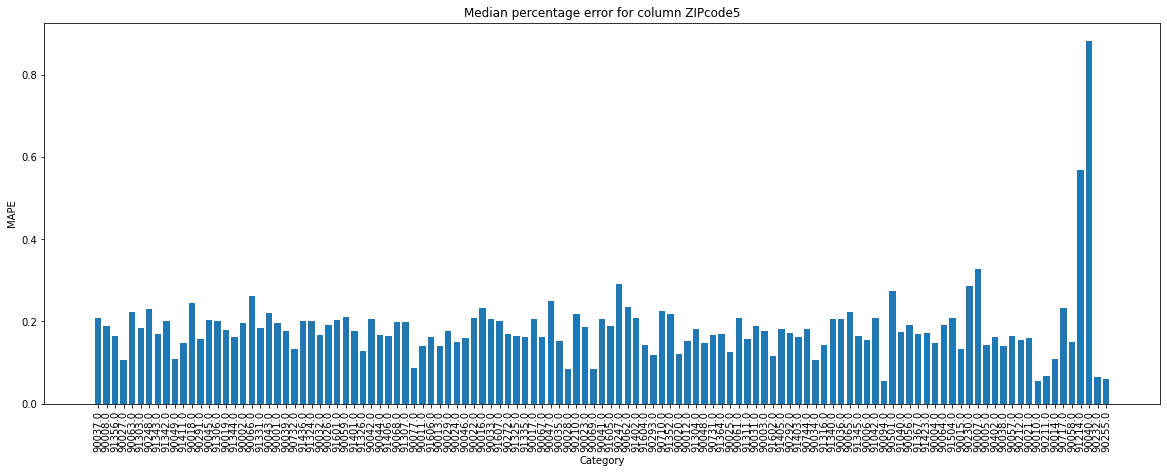

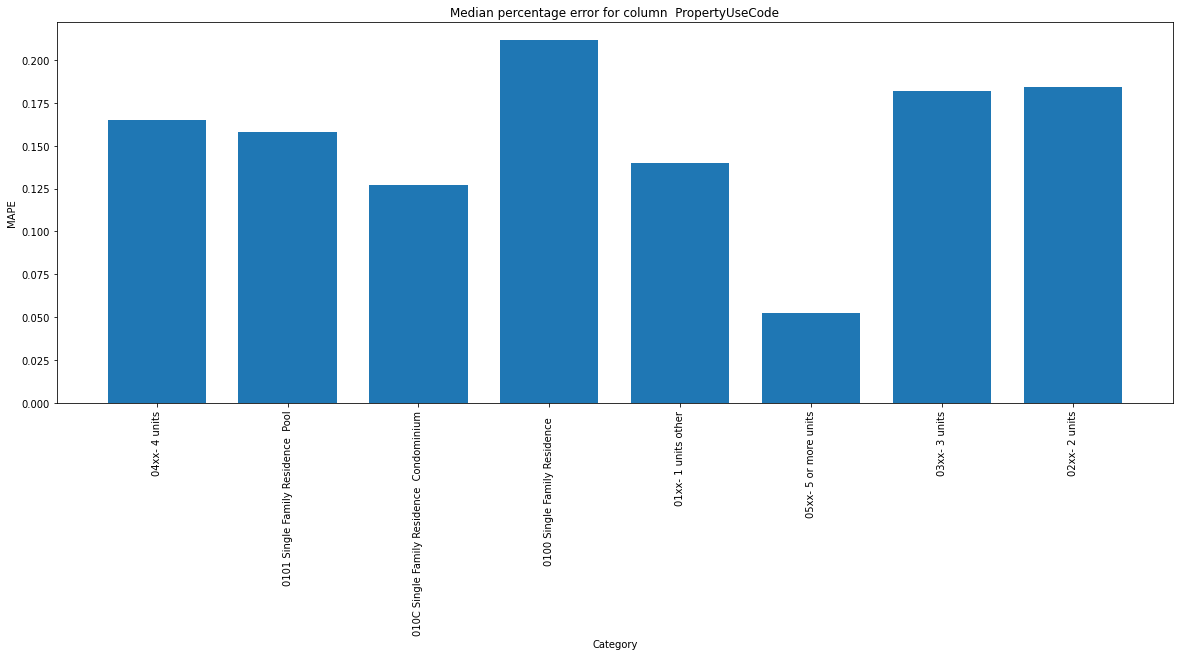

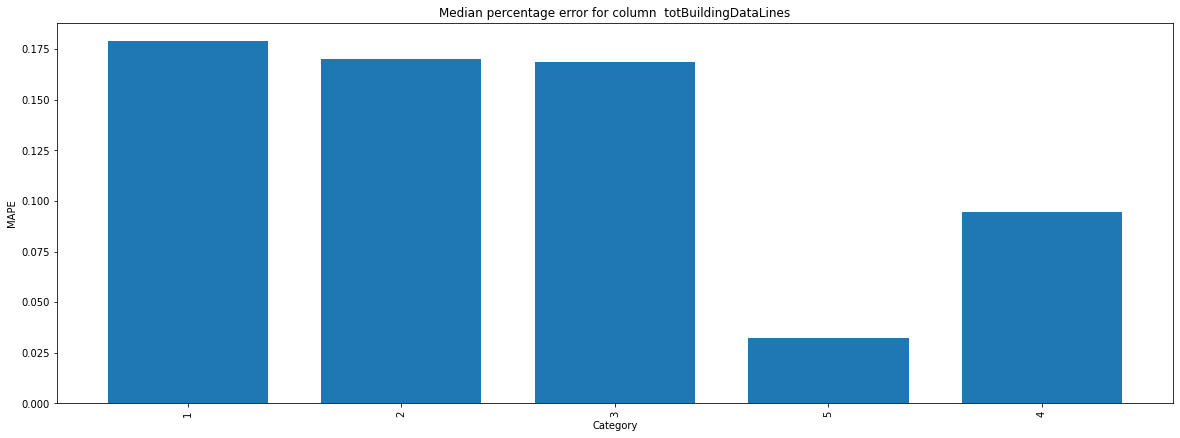

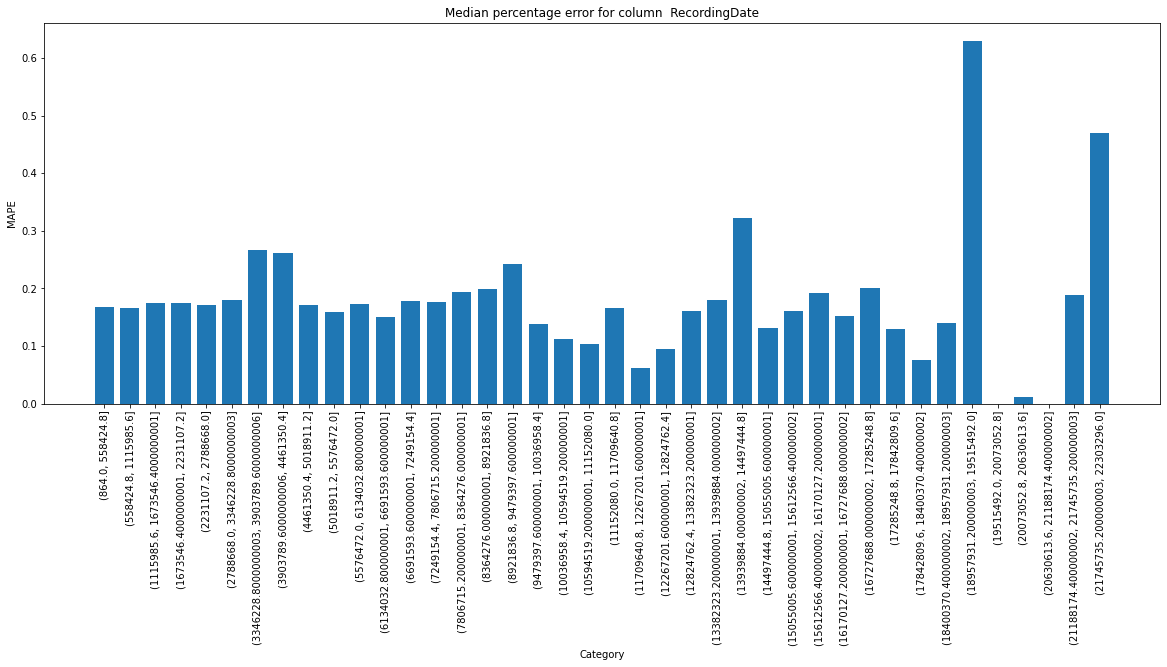

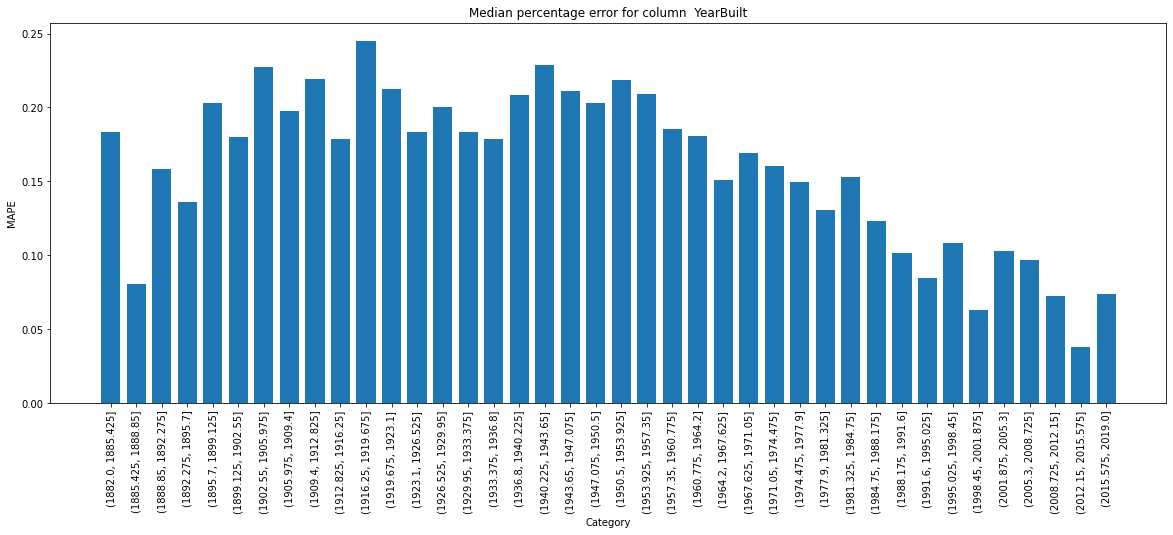

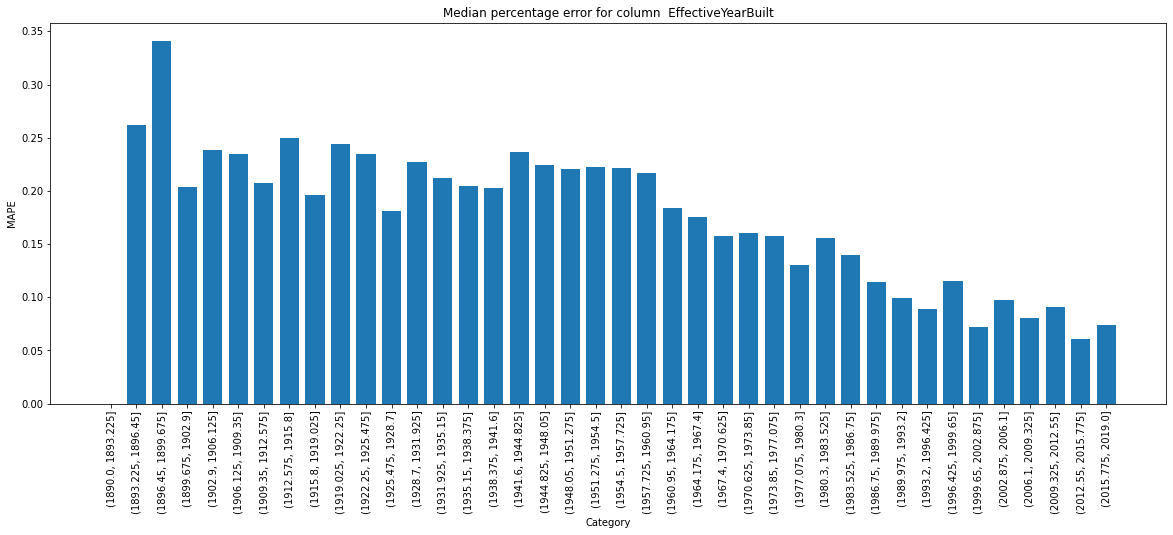

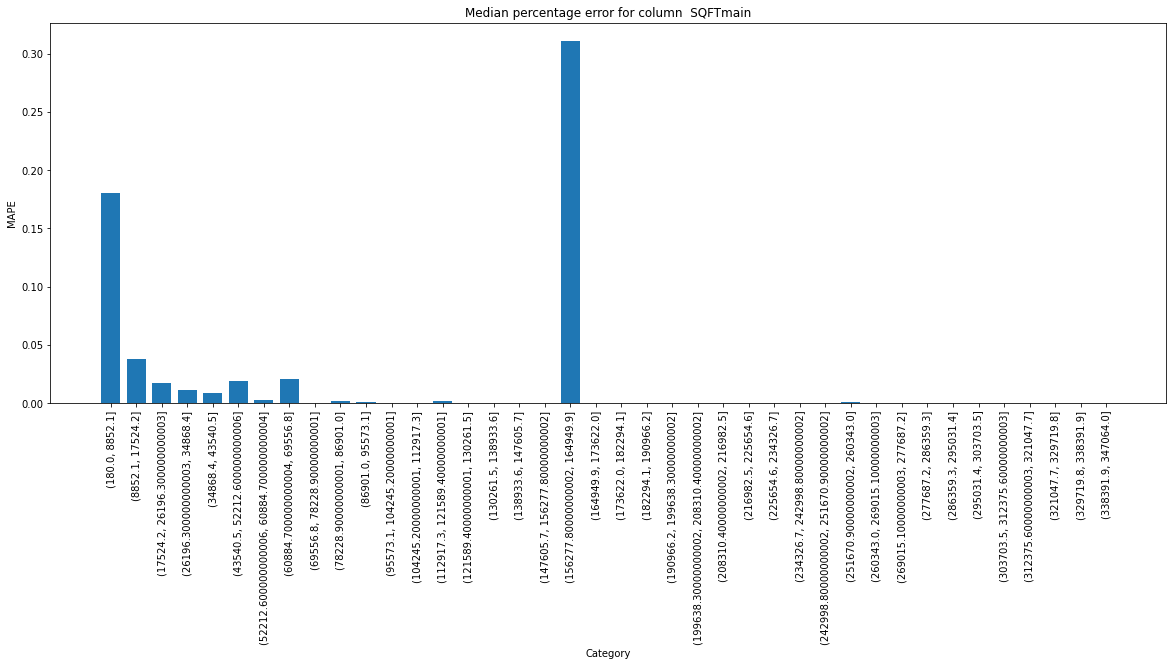

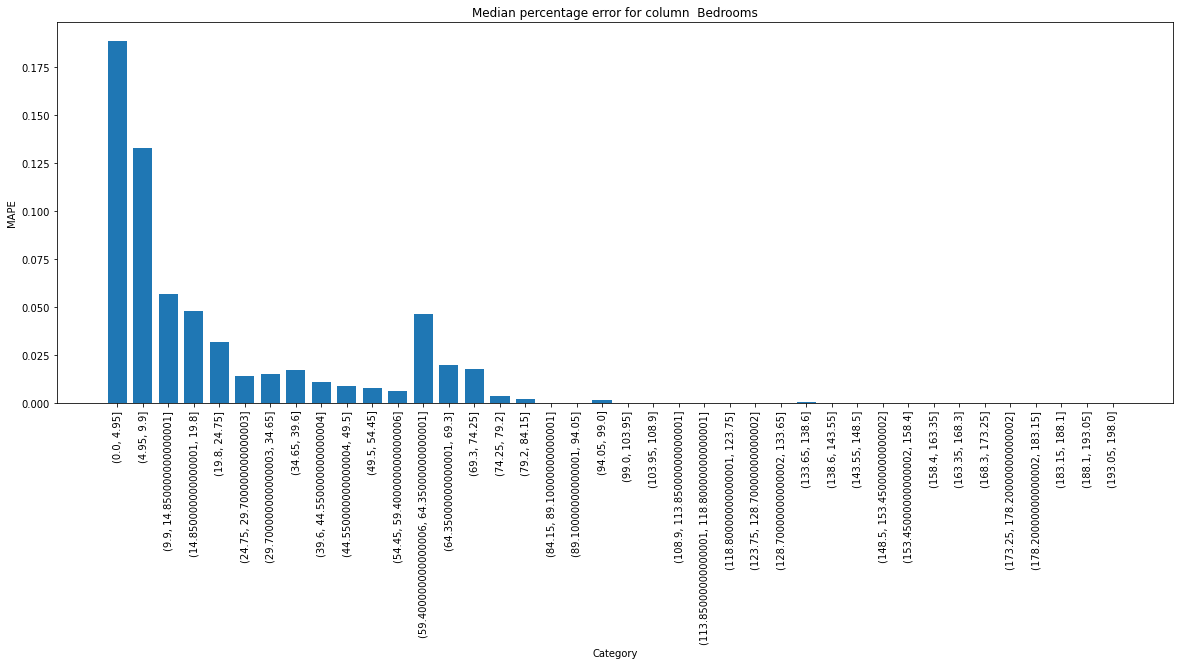

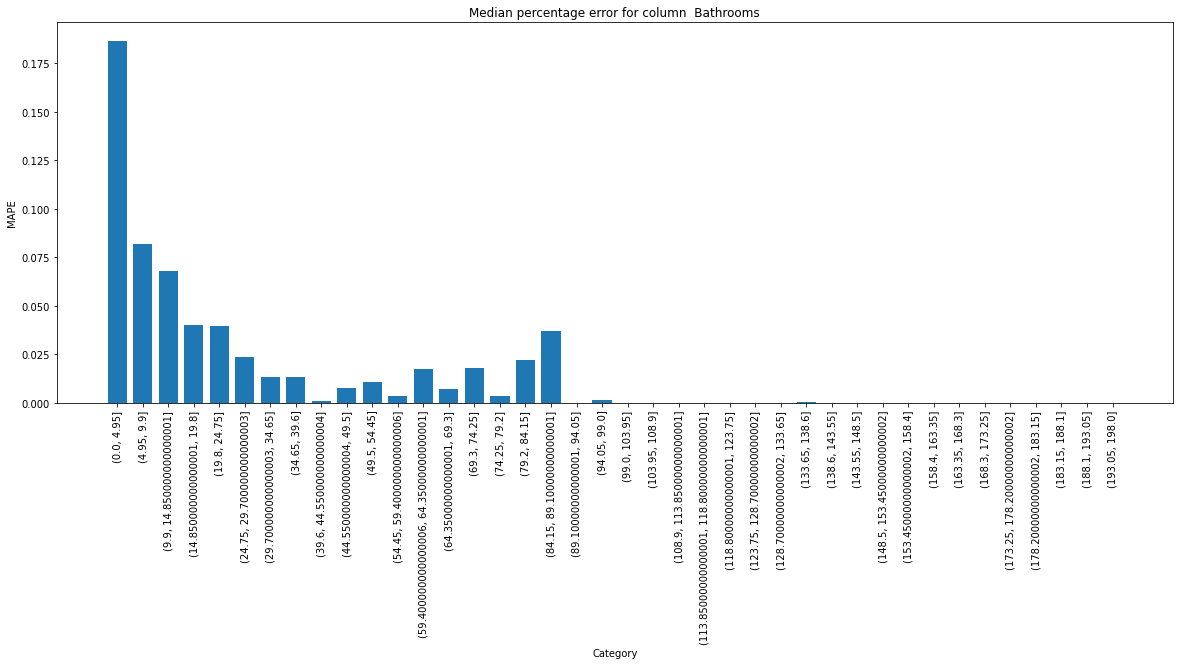

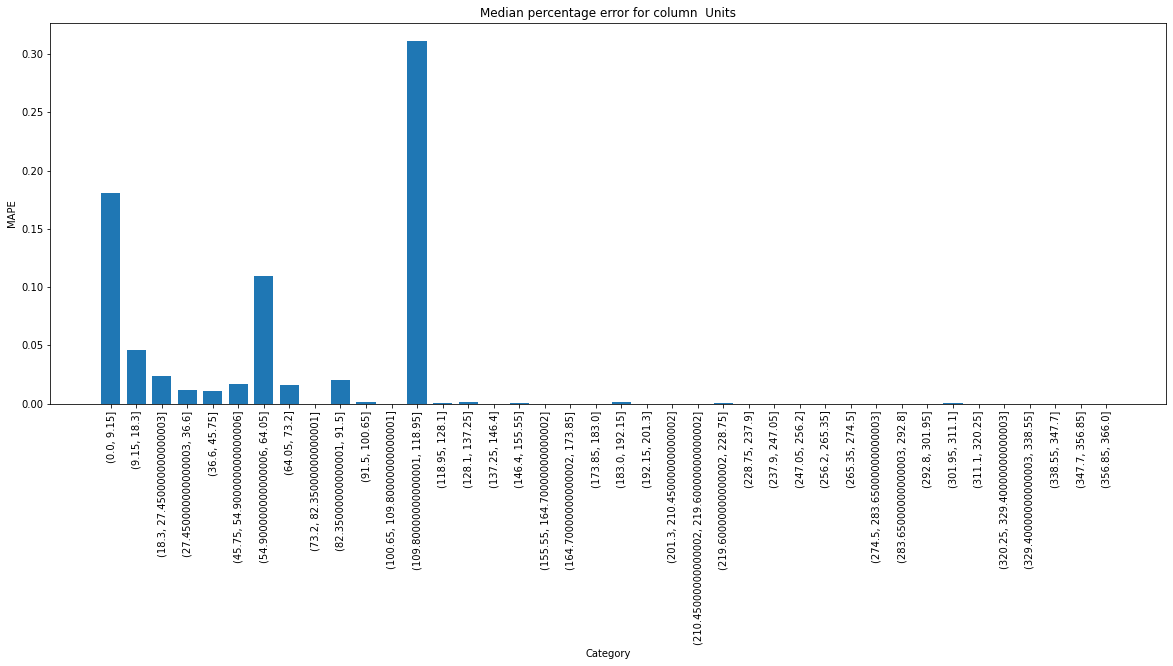

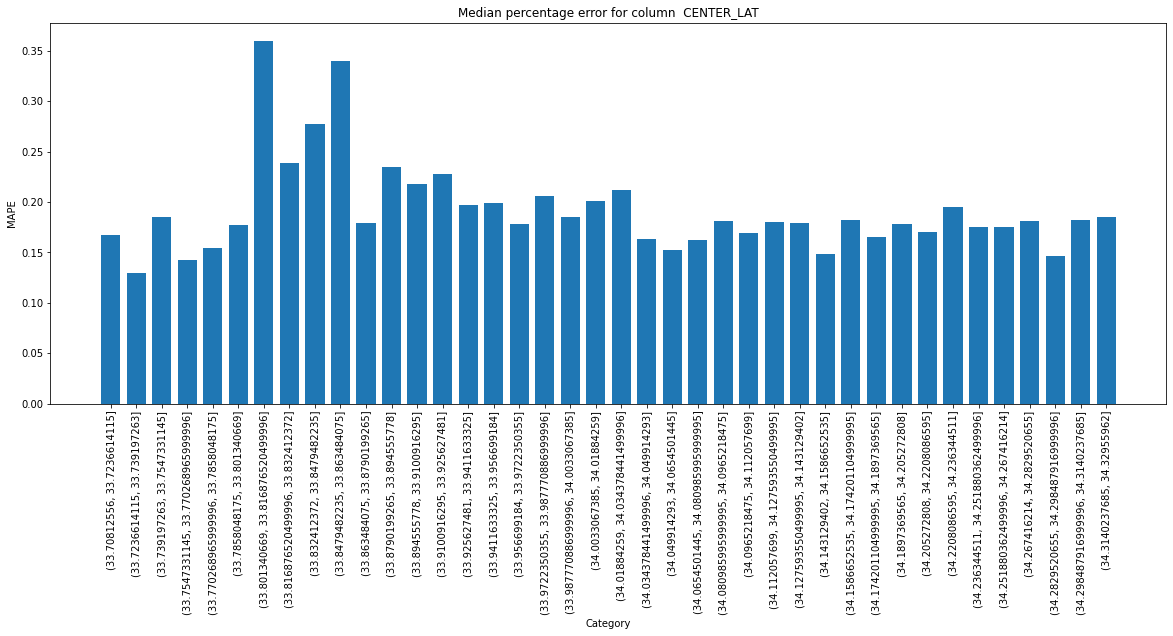

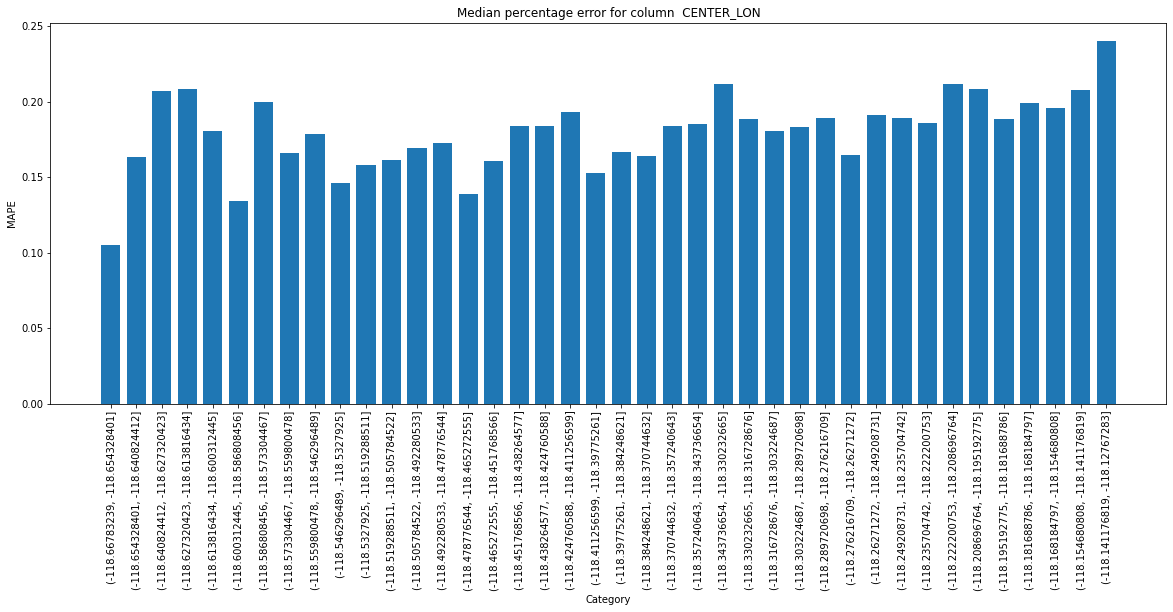

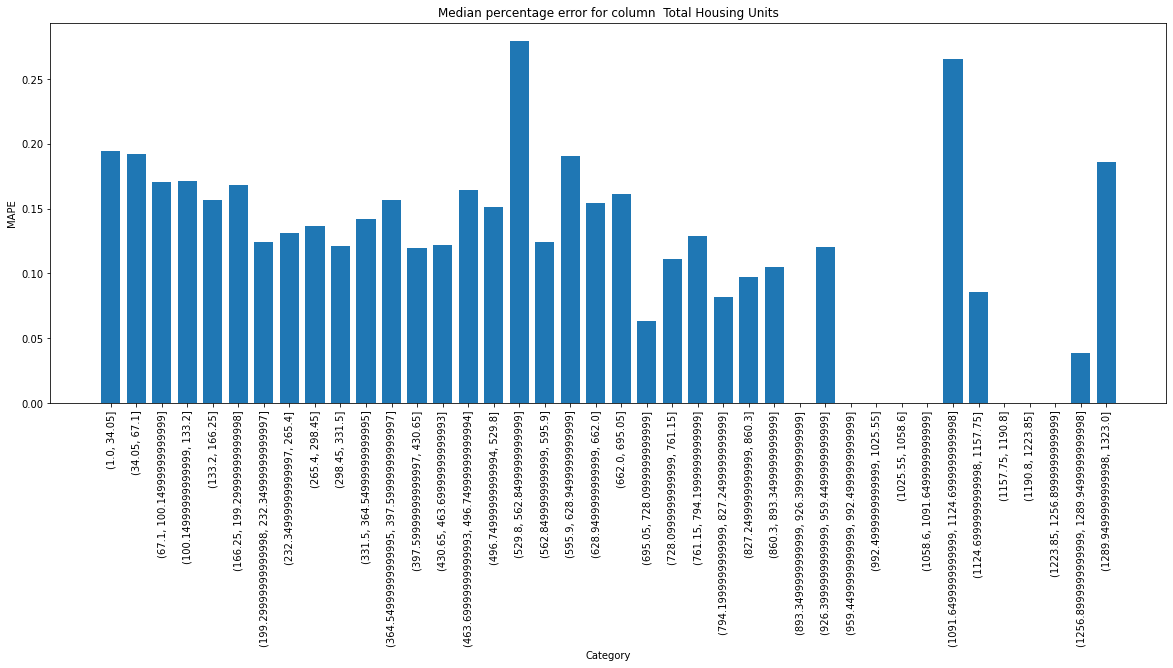

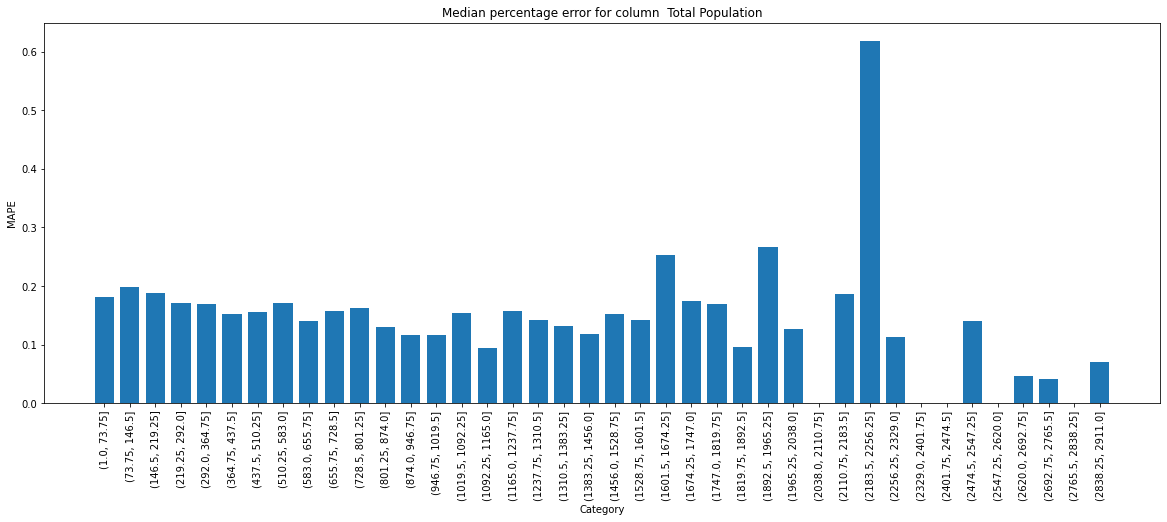

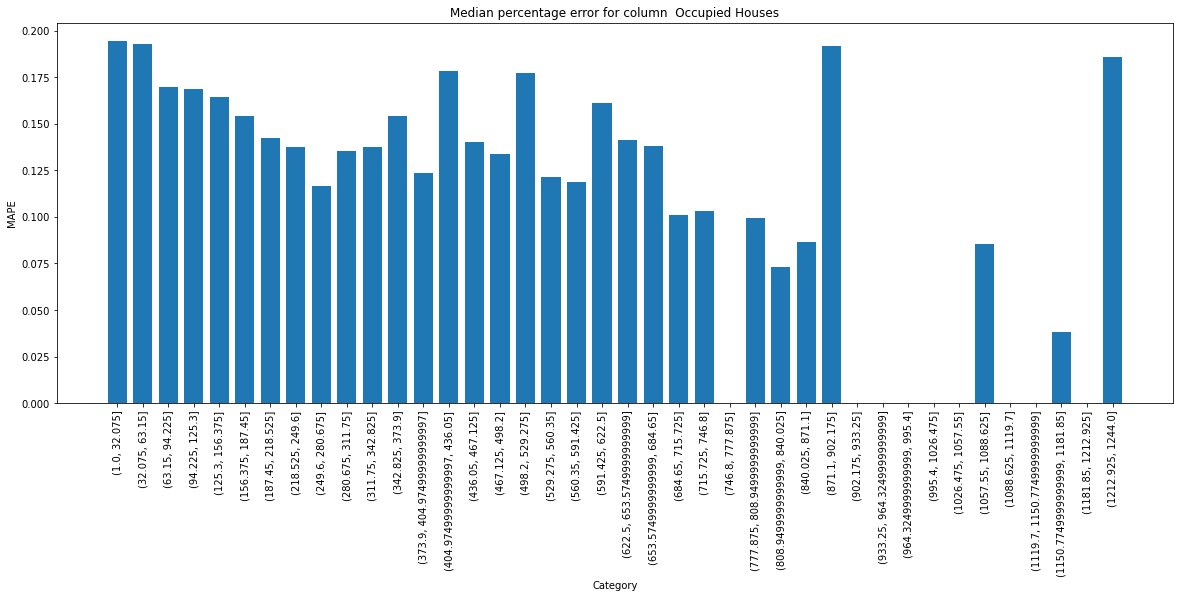

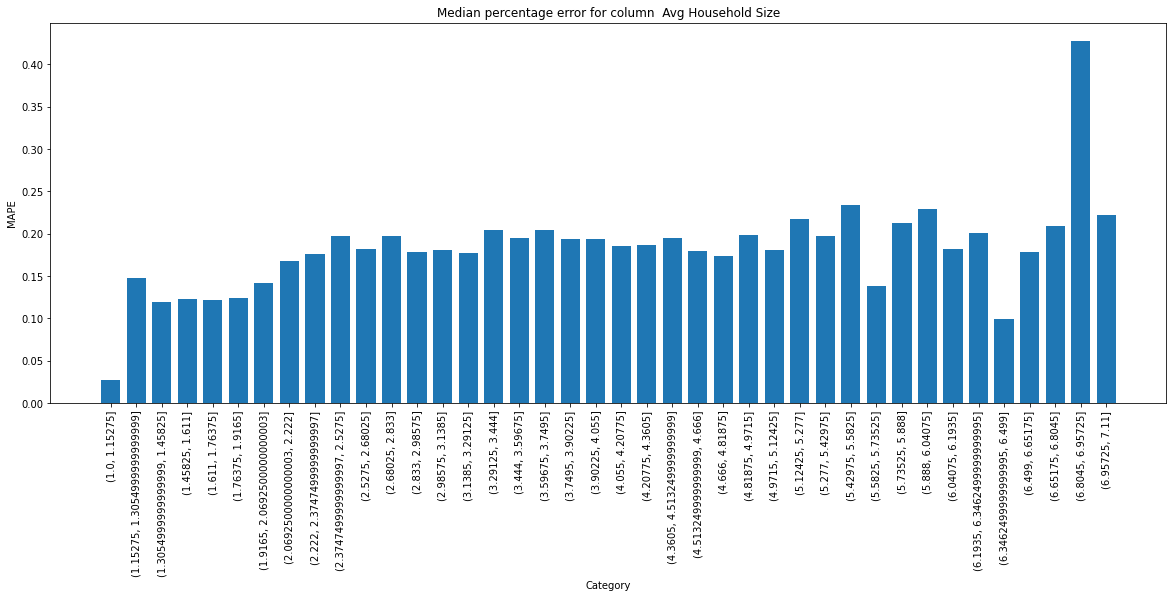

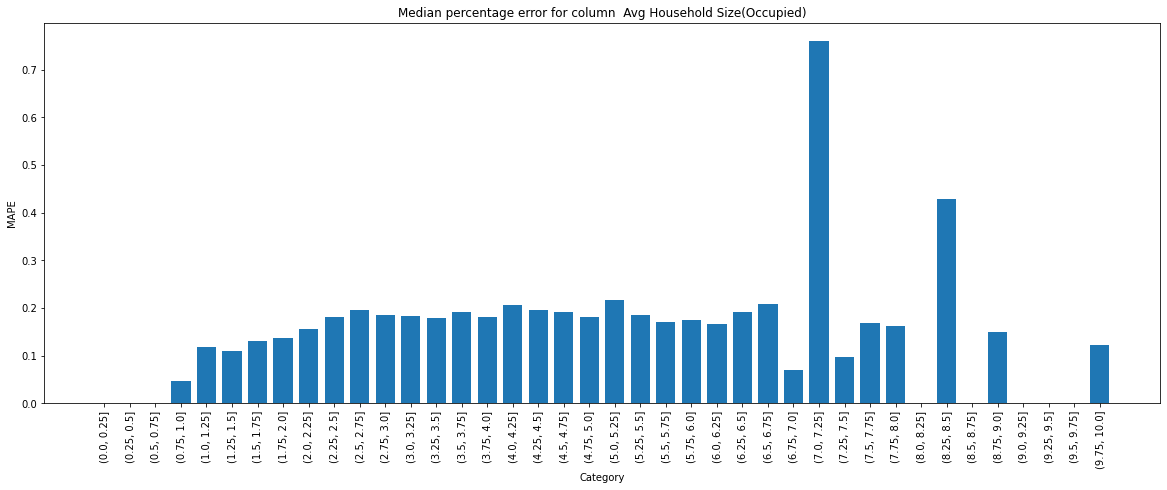

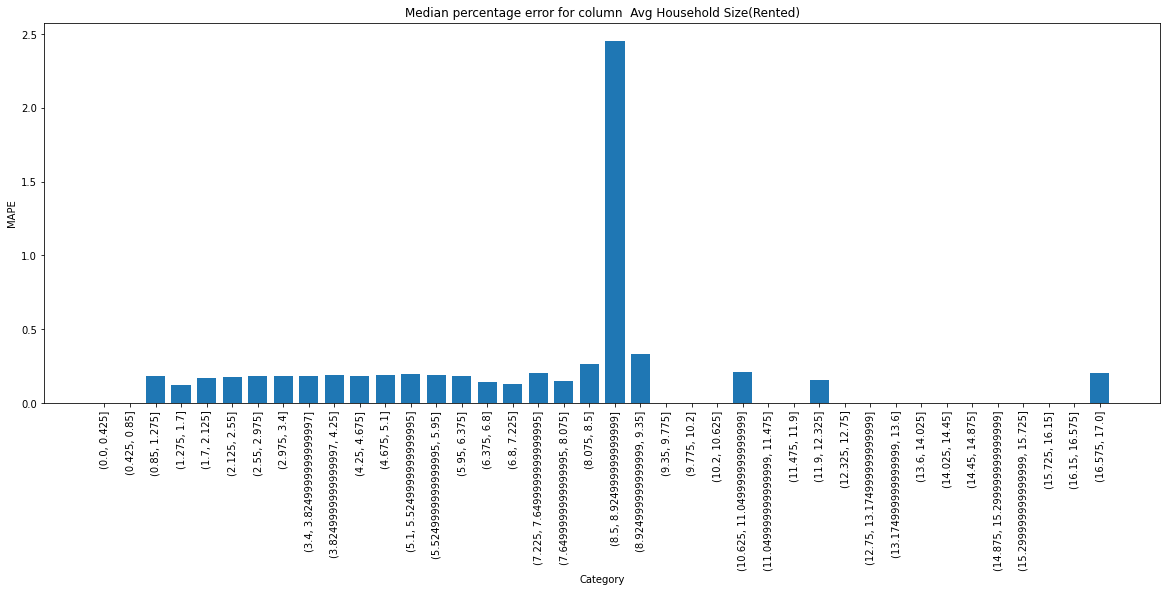

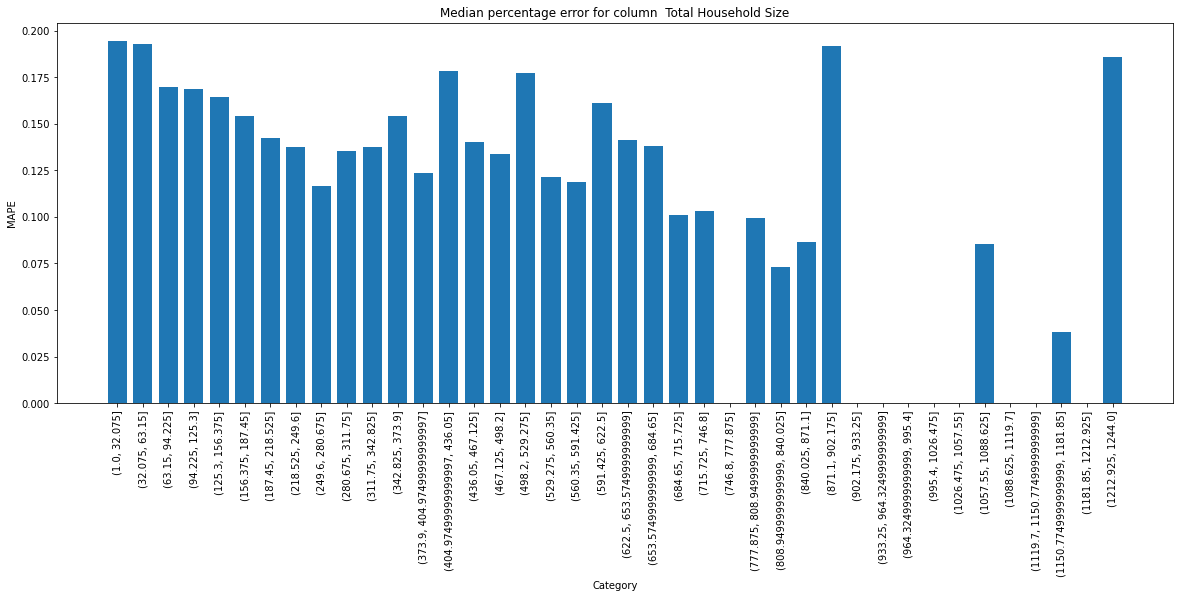

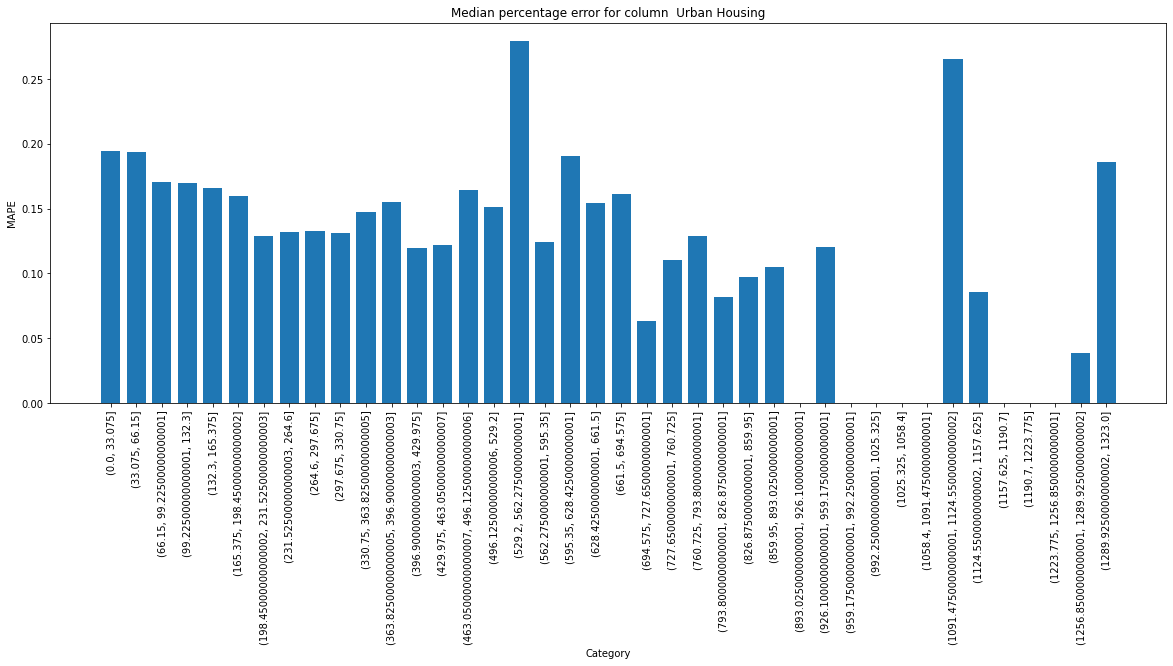

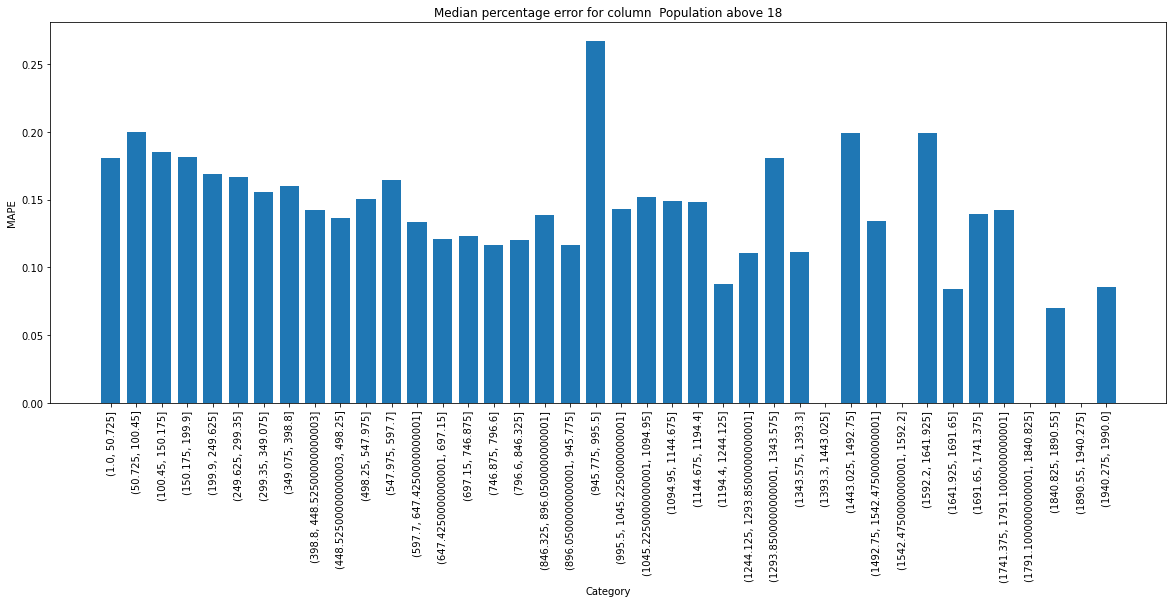

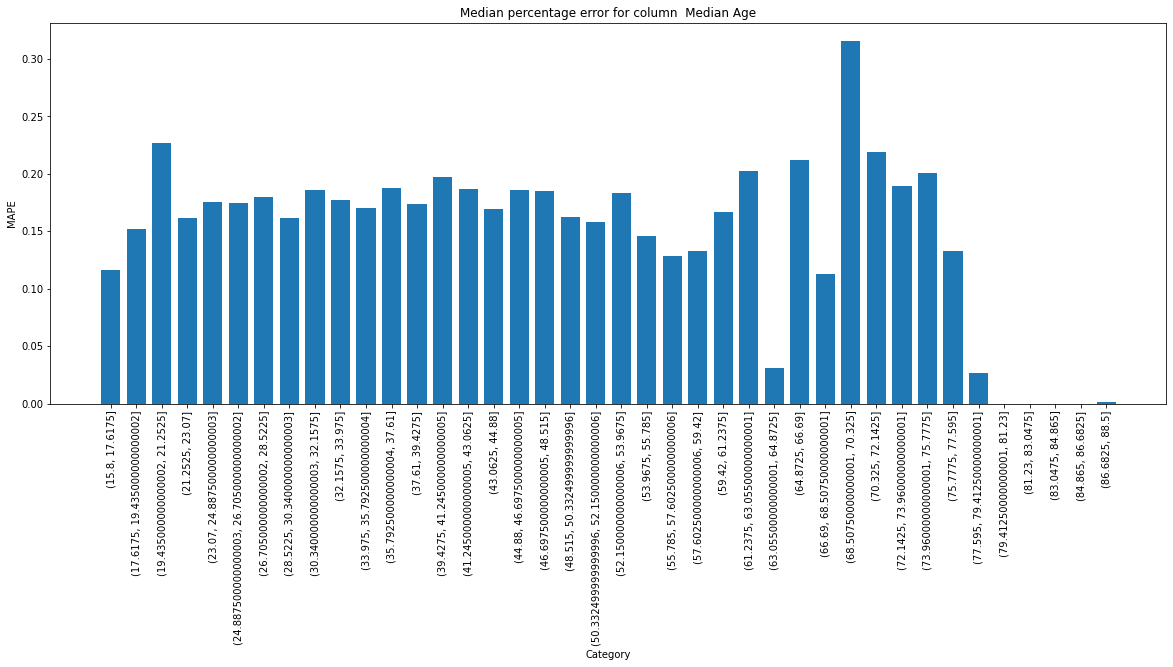

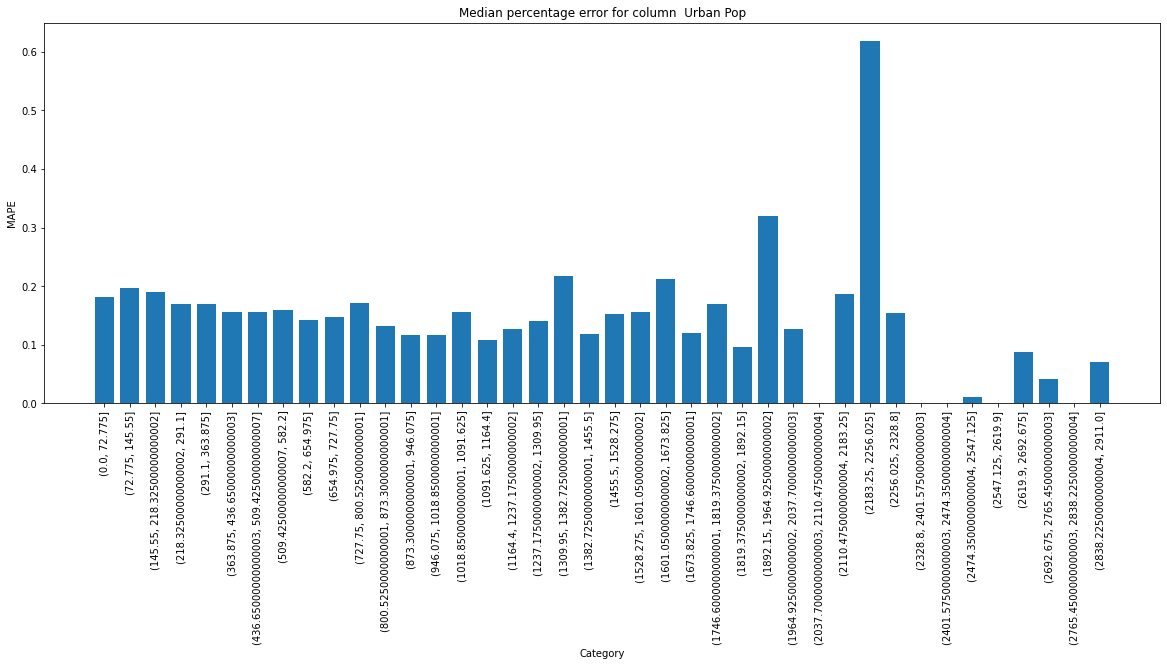

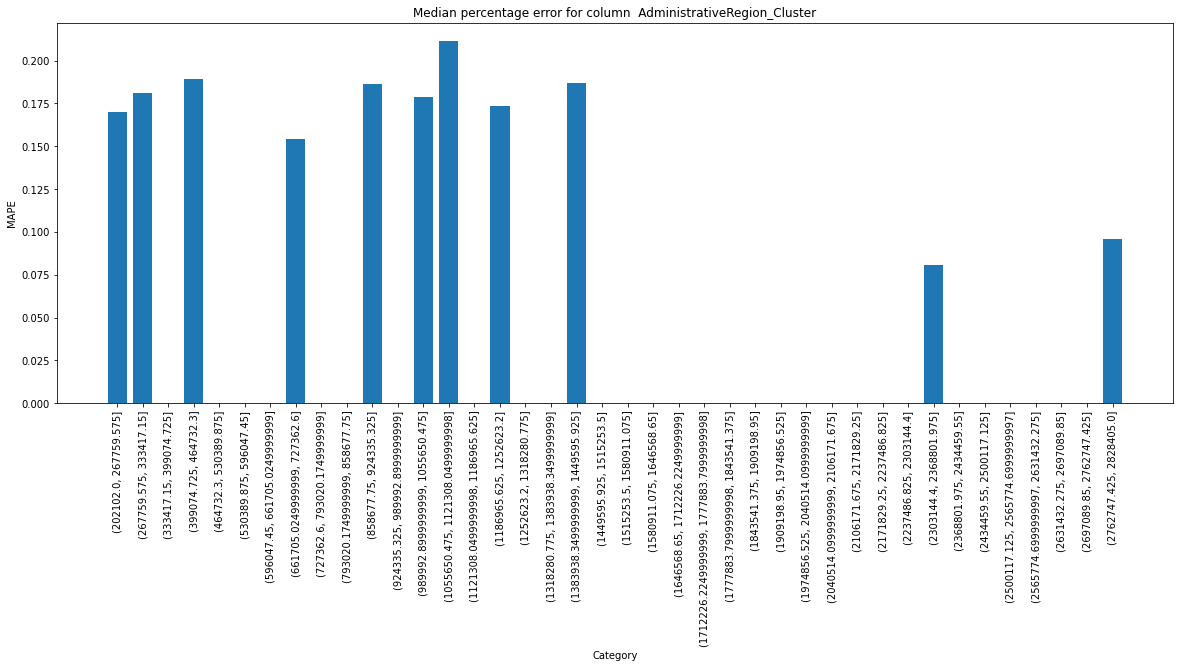

In [95]:
#running grupwise err analysis
errcols = err_analysis2(X,y,my_pipeline.predict(X))

In [96]:
# above error analysis following things can be inferred - 
# ZIPcode5 has lots of categories and there's no info on grouping these categories together can be figured out using analysis
# Moreover since we are using forest based models, spatial apace can be split into relevant partitions based on co-ordinate itself
# hence dropping ZIPcode5 column
# for recording date i.e. transformed difference between 1 Jan 2109 and recording date 
# it's observed that for bins with larger values median % err is high i.e model is performing bad for older recorded houses
# same trend is seen for houses which are very old (year build, effective year build)
# Model tends to perform worse for houses with small SQFTmain i.e main area
# A large error is also observed for a narrow set of properties having SQFTmain around 16000 sqft
# This trend is also seen for other signifiers of property size - Bedrooms,Bathrooms,Units
# This ties in individual error analysis performed before this step and EDA
# SQFTmain,Bedrooms,Bathrooms,Units were highly correlated to TotalValue
# Therefore large error is seen for properties with low TotalValue and for a narrow set in between
# Small no. of points are present in this narraw set
# Some sort of outlier seems to be present in the set whose value can't be captured by the model/or insufficient data to fully describe the property 
# Possible reasons can be a large property which is very old/ needs a lot of repairing and upkeep or on flip side a property with unique features/location
# As average size of properties in a block increases model's error % also increases i.e. Properties in areas with larger properties are difficult to asses by model
# Large error% for narrow set of Avg. Household size (both occupied and rented), Urban pop seems to confirm presence of some outliers
# these outliers could be same as those observed with SQFTmain
# finding these outliers and dropping them

In [97]:
# ind is the set for all the rows containing categories causing high err

ind = set()

col = "RecordingDate"
val = errcols[col]
for v in val:
    if v[1]>=0.3:
        points = X[:][(X[col]<=v[0].right)&(X[col]>v[0].left)]
        qw = set(points.index)
        ind = ind.union(qw)

col = "EffectiveYearBuilt"
val = errcols[col]
for v in val:
    if v[1]>=0.25:
        points = X[:][(X[col]<=v[0].right)&(X[col]>v[0].left)]
        qw = set(points.index)
        ind = ind.union(qw)

col = "SQFTmain"
val = errcols[col]
for v in val:
    if v[1]>=0.2:
        points = X[:][(X[col]<=v[0].right)&(X[col]>v[0].left)]
        qw = set(points.index)
        ind = ind.union(qw)

col = "Bedrooms"
val = errcols[col]
for v in val:
    if v[1]>=0.2:
        points = X[:][(X[col]<=v[0].right)&(X[col]>v[0].left)]
        qw = set(points.index)
        ind = ind.union(qw)

col = "Bathrooms"
val = errcols[col]
for v in val:
    if v[1]>=0.2:
        points = X[:][(X[col]<=v[0].right)&(X[col]>v[0].left)]
        qw = set(points.index)
        ind = ind.union(qw)

col = "Units"
val = errcols[col]
for v in val:
    if v[1]>=0.2:
        points = X[:][(X[col]<=v[0].right)&(X[col]>v[0].left)]
        qw = set(points.index)
        ind = ind.union(qw)

col = "Total Population"
val = errcols[col]
for v in val:
    if v[1]>=0.25:
        points = X[:][(X[col]<=v[0].right)&(X[col]>v[0].left)]
        qw = set(points.index)
        ind = ind.union(qw)

col = 'Avg Household Size'
val = errcols[col]
for v in val:
    if v[1]>=0.25:
        points = X[:][(X[col]<=v[0].right)&(X[col]>v[0].left)]
        qw = set(points.index)
        ind = ind.union(qw)

col = 'Avg Household Size(Occupied)'
val = errcols[col]
for v in val:
    if v[1]>=0.25:
        points = X[:][(X[col]<=v[0].right)&(X[col]>v[0].left)]
        qw = set(points.index)
        ind = ind.union(qw)

col = 'Avg Household Size(Rented)'
val = errcols[col]
for v in val:
    if v[1]>=0.25:
        points = X[:][(X[col]<=v[0].right)&(X[col]>v[0].left)]
        qw = set(points.index)
        ind = ind.union(qw)

col = 'Urban Pop'
val = errcols[col]
for v in val:
    if v[1]>=0.25:
        points = X[:][(X[col]<=v[0].right)&(X[col]>v[0].left)]
        qw = set(points.index)
        ind = ind.union(qw)
len(ind)

45

In [98]:
dictt={}
i = 0
for x in numerical_cols+c1_cols+['PropertyUseCode'+str(x) for x in range(0,df['PropertyUseCode'].nunique())]+["totBuildingDataLines"+str(x) for x in range(0,df['totBuildingDataLines'].nunique())]:
    dictt[i]=x
    i=i+1
dictt

{0: 'RecordingDate',
 1: 'YearBuilt',
 2: 'EffectiveYearBuilt',
 3: 'SQFTmain',
 4: 'Bedrooms',
 5: 'Bathrooms',
 6: 'Units',
 7: 'CENTER_LAT',
 8: 'CENTER_LON',
 9: 'Total Housing Units',
 10: 'Total Population',
 11: 'Occupied Houses',
 12: 'Avg Household Size',
 13: 'Avg Household Size(Occupied)',
 14: 'Avg Household Size(Rented)',
 15: 'Total Household Size',
 16: 'Urban Housing',
 17: 'Population above 18',
 18: 'Median Age',
 19: 'Urban Pop',
 20: 'AdministrativeRegion_Cluster',
 21: 'ZIPcode5',
 22: 'PropertyUseCode0',
 23: 'PropertyUseCode1',
 24: 'PropertyUseCode2',
 25: 'PropertyUseCode3',
 26: 'PropertyUseCode4',
 27: 'PropertyUseCode5',
 28: 'PropertyUseCode6',
 29: 'PropertyUseCode7',
 30: 'totBuildingDataLines0',
 31: 'totBuildingDataLines1',
 32: 'totBuildingDataLines2',
 33: 'totBuildingDataLines3',
 34: 'totBuildingDataLines4'}

{0: 'RecordingDate', 1: 'YearBuilt', 2: 'EffectiveYearBuilt', 3: 'SQFTmain', 4: 'Bedrooms', 5: 'Bathrooms', 6: 'Units', 7: 'CENTER_LAT', 8: 'CENTER_LON', 9: 'Total Housing Units', 10: 'Total Population', 11: 'Occupied Houses', 12: 'Avg Household Size', 13: 'Avg Household Size(Occupied)', 14: 'Avg Household Size(Rented)', 15: 'Total Household Size', 16: 'Urban Housing', 17: 'Population above 18', 18: 'Median Age', 19: 'Urban Pop', 20: 'AdministrativeRegion_Cluster', 21: 'ZIPcode5', 22: 'PropertyUseCode0', 23: 'PropertyUseCode1', 24: 'PropertyUseCode2', 25: 'PropertyUseCode3', 26: 'PropertyUseCode4', 27: 'PropertyUseCode5', 28: 'PropertyUseCode6', 29: 'PropertyUseCode7', 30: 'totBuildingDataLines0', 31: 'totBuildingDataLines1', 32: 'totBuildingDataLines2', 33: 'totBuildingDataLines3', 34: 'totBuildingDataLines4'}


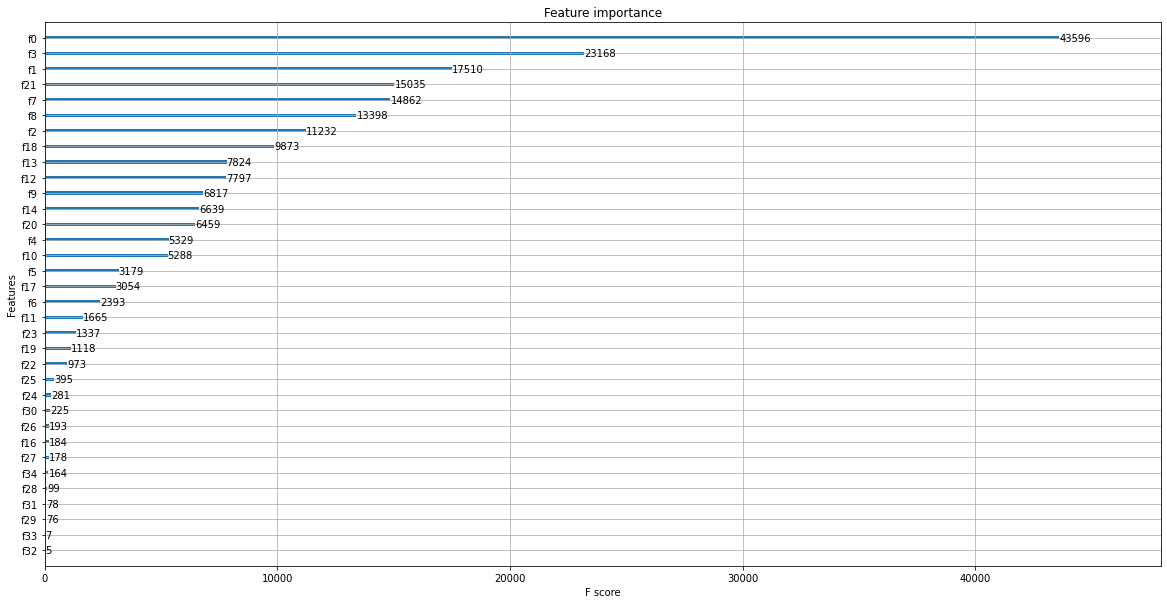

In [99]:
#Analysing feature importance 
#Note that f-score here is count, a variabnle appeared in different trees after splitting
# dictt above has the name for features
from xgboost import plot_importance
print(dictt)
f,ax = plt.subplots(figsize=(20,10))
plot_importance(xgb,ax=ax)

In [100]:
# note that categorical features are the least important espacially totBuildingLines
# zip code as almost same importance as latitude and longitude
# RecordingDate, SQFTmain, EffectiveYearBuilt are most important features

In [118]:
# 'ZIPcode5'
# was part of c1_cols (has large no. of categories) 
# forest based methods consume co-ordinate info to map out spatial function
# excluding ZIPcode5 was giving better results
# dropping outliers and retraining the model

df1 = df.drop(index=ind)
y = np.array(df1['TotalValue'])
X = df1.drop(['TotalValue'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=4322)
c1_cols = []
c2_cols = ['PropertyUseCode','totBuildingDataLines']
numerical_cols = ['RecordingDate', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain',
       'Bedrooms', 'Bathrooms', 'Units', 'CENTER_LAT',
       'CENTER_LON', 'Total Housing Units', 'Total Population',
       'Occupied Houses', 'Avg Household Size', 
       'Avg Household Size(Occupied)',
       'Avg Household Size(Rented)',
       'Total Household Size', 'Urban Housing',
       'Population above 18', 'Median Age', 'Urban Pop',
       'AdministrativeRegion_Cluster']
# Preprocessing for numerical data
numerical_transformer = StandardScaler()
# Preprocessing for categorical data type 1 (one hot encoding)
categorical_transformer1 = CatBoostEncoder()
# Preprocessing for categorical data type 2 (label encoding)
categorical_transformer2 = OneHotEncoder()

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
#    ('cat1', categorical_transformer1, c1_cols),
    ('cat2', categorical_transformer2, c2_cols)])
xgb2 = XGBRegressor(learning_rate = 0.01, max_depth = 10, n_estimators= 1300)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb2)
                             ])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
xgb2.fit(X_train,y_train,eval_metric=['rmse'], eval_set=[(X_test, y_test)], verbose=True)
y_train_hat = xgb2.predict(X_train)
y_test_hat = xgb2.predict(X_test)
print("RMSE on train set without transformations:",np.sqrt(((y_train_hat-y_train)**2).mean()))
print("RMSE on test set without transformations:",np.sqrt(((y_test_hat-y_test)**2).mean()))
print("MAE on train set without transformations:",abs(y_train_hat-y_train).mean())
print("MAE on test set without transformations:",abs(y_test_hat-y_test).mean())
print("MAvE on train set without transformations:",median(abs(y_train_hat-y_train)))
print("MAvE on test set without transformations:",median(abs(y_test_hat-y_test)))
print("example: predicted, actual")
for i in range(10):
  print(y_test_hat[i],y_test[i])

[09:14:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.17011e+06
[1]	validation_0-rmse:5.153e+06
[2]	validation_0-rmse:5.13603e+06
[3]	validation_0-rmse:5.11918e+06
[4]	validation_0-rmse:5.10252e+06
[5]	validation_0-rmse:5.08593e+06
[6]	validation_0-rmse:5.06946e+06
[7]	validation_0-rmse:5.05317e+06
[8]	validation_0-rmse:5.03695e+06
[9]	validation_0-rmse:5.02084e+06
[10]	validation_0-rmse:5.00479e+06
[11]	validation_0-rmse:4.98895e+06
[12]	validation_0-rmse:4.97324e+06
[13]	validation_0-rmse:4.95753e+06
[14]	validation_0-rmse:4.94209e+06
[15]	validation_0-rmse:4.9269e+06
[16]	validation_0-rmse:4.91185e+06
[17]	validation_0-rmse:4.89681e+06
[18]	validation_0-rmse:4.88199e+06
[19]	validation_0-rmse:4.86708e+06
[20]	validation_0-rmse:4.85236e+06
[21]	validation_0-rmse:4.83787e+06
[22]	validation_0-rmse:4.82346e+06
[23]	validation_0-rmse:4.80904e+06
[24]	validation_0-rmse:4.79464e+06
[25]	valida

In [102]:
#It appears as if model is overfitting, need to tune parameters

In [103]:
my_pipeline[-1]

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [121]:
# hyper parameter tuning for xgboost
# training final model on complete set
from sklearn.model_selection import GridSearchCV
param_grid = [{"model__learning_rate"    : [ 0.01 ],
               "model__max_depth"        : [ 6, 8, 10],
               "model__min_child_weight" : [ 1, 3, 5],
               "model__gamma"            : [ 0.0, 0.1],
               "model__n_estimators"     : [1000, 1500, 3000],
               }]
grid_search = GridSearchCV(my_pipeline,param_grid,n_jobs=-1,cv=5,scoring='neg_mean_absolute_error',return_train_score=True)
grid_search.fit(X,y)
joblib.dump(grid_search.best_estimator_,"best_model.pkl")


[11:56:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


['best_model.pkl']

In [128]:
my_pipeline = grid_search.best_estimator_

In [129]:
y_hat = my_pipeline.predict(X)
print("RMSE on set :",np.sqrt(((y-y_hat)**2).mean()))
print("MAE on set :",abs(y-y_hat).mean())
print("Median AE on set :",median(abs(y-y_hat)))
print("example: predicted, actual")
for i in range(10):
  print(y_hat[i],y[i])

RMSE on set : 261240.62992106067
MAE on set : 166623.32138536728
Median AE on set : 109068.78125
example: predicted, actual
313693.53 518831
184331.27 61491
332103.8 371695
413469.84 486420
114152.02 230863
174198.2 181316
375481.6 447774
338335.62 348108
315859.75 247260
332126.6 270793


In [124]:
grid_search.best_params_

{'model__gamma': 0.0,
 'model__learning_rate': 0.01,
 'model__max_depth': 8,
 'model__min_child_weight': 3,
 'model__n_estimators': 1500}

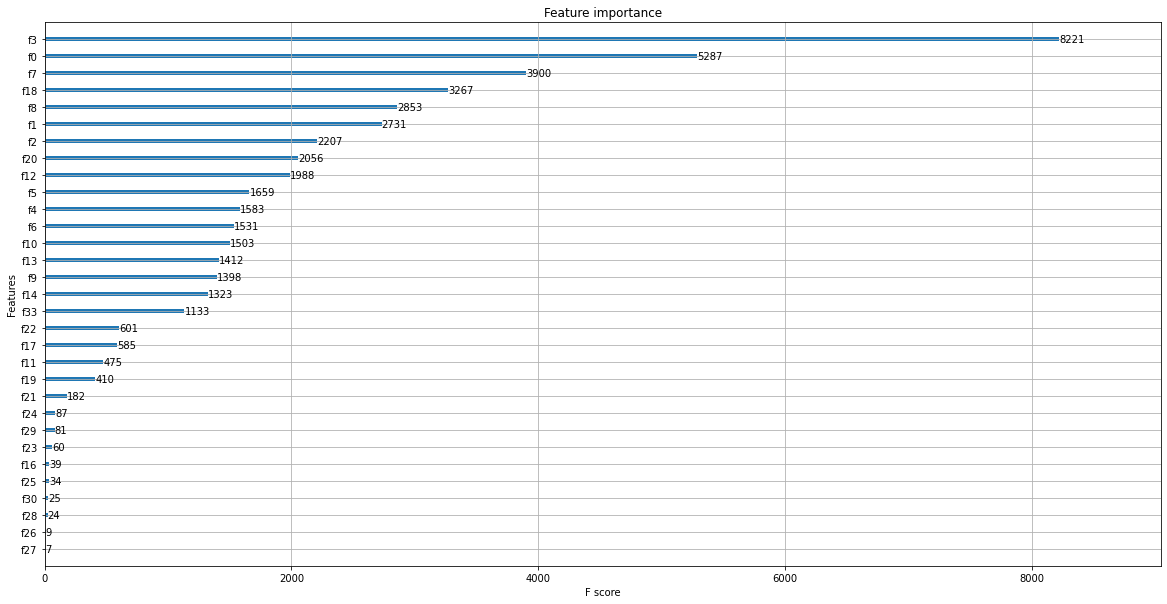

In [133]:
f,ax = plt.subplots(figsize=(20,10))
plot_importance(grid_search.best_estimator_[-1],ax=ax)

In [138]:
# note that feature importance has changed - SQFTmain is the most important feature now follwed by recordingDate

In [139]:
from sklearn.metrics import r2_score
r2 = r2_score(y, y_hat)
print("R2 score for final model: ", r2)

R2 score for final model:  0.9828916783945469
